# LightGBM using TPE Search by Optuna
https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/

This is an intermediate-level practice competition.

The below model ranked the top **1.6%** on the leader board

Based on aspects of building location and construction, our goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.

We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

1. represents low damage
2. represents a medium amount of damage
3. represents almost complete destruction

**Features**

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.

There are 39 columns in this dataset, where the building_id column is a unique and random identifier. Categorical variables have been obfuscated random lowercase ascii characters. The appearance of the same character in distinct columns does not imply the same original value.

## Summary
Three main techniques were used to improve the model performance:

**1. Target Encoding for data preprocessing**
- Target encoding is a simple and quick encoding method that doesn’t add to the dimensionality of the dataset. 

**2. LightGBM for model building**
- Faster training speed and higher efficiency
- Lower memory usage
- Better accuracy
- Support of parallel and GPU learning
- Capable of handling large-scale data
- Capable of handling missing values
- Capable of handling outlier
- Deal imbalanced data internally
- Target Encoding internally

**3. TPE Search for hyperparameter tuning**
- The Tree-structured Parzen Estimator (TPE) is a sequential model-based optimization (SMBO) approach. SMBO methods sequentially construct models to approximate the performance of hyperparameters based on historical measurements, and then subsequently choose new hyperparameters to test based on this model. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## 1. Loading Data

In [2]:
df_x = pd.read_csv('train_values.csv')
df_y = pd.read_csv('train_labels.csv')

In [3]:
df = df_x.merge(df_y, left_on='building_id', right_on = 'building_id')

In [4]:
df.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## 2. EDA

In [5]:
# check for the data size
print(f"rows: {df.shape[0]}")
print(f"columns: {df.shape[1]}")

rows: 260601
columns: 40


In [6]:
# check null values
df.isna().values.any()

False

No null values found

In [7]:
# check duplicated value
# df.T.duplicated()

No duplicated value found

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

The data is large, it has a multi-class objective, and the most valuable features are categorical with many categories/levels.

In [9]:
df.nunique()

building_id                               260601
geo_level_1_id                                31
geo_level_2_id                              1414
geo_level_3_id                             11595
count_floors_pre_eq                            9
age                                           42
area_percentage                               84
height_percentage                             27
land_surface_condition                         3
foundation_type                                5
roof_type                                      3
ground_floor_type                              5
other_floor_type                               4
position                                       4
plan_configuration                            10
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_superstructure_stone_flag                  2
has_superstructure_cement_mortar_stone         2
has_superstructure_mud_mortar_brick            2
has_superstructure_c

We spotted some features are the binary data.

In [10]:
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


Seems like there some outliers in the feature age

<AxesSubplot:xlabel='age'>

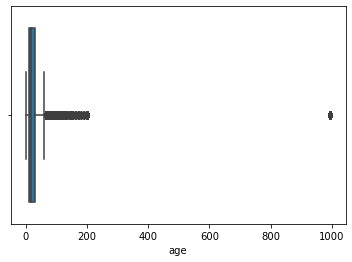

In [11]:
# Visualize the outliers
sns.boxplot(df['age'])

Let's leave it for now.

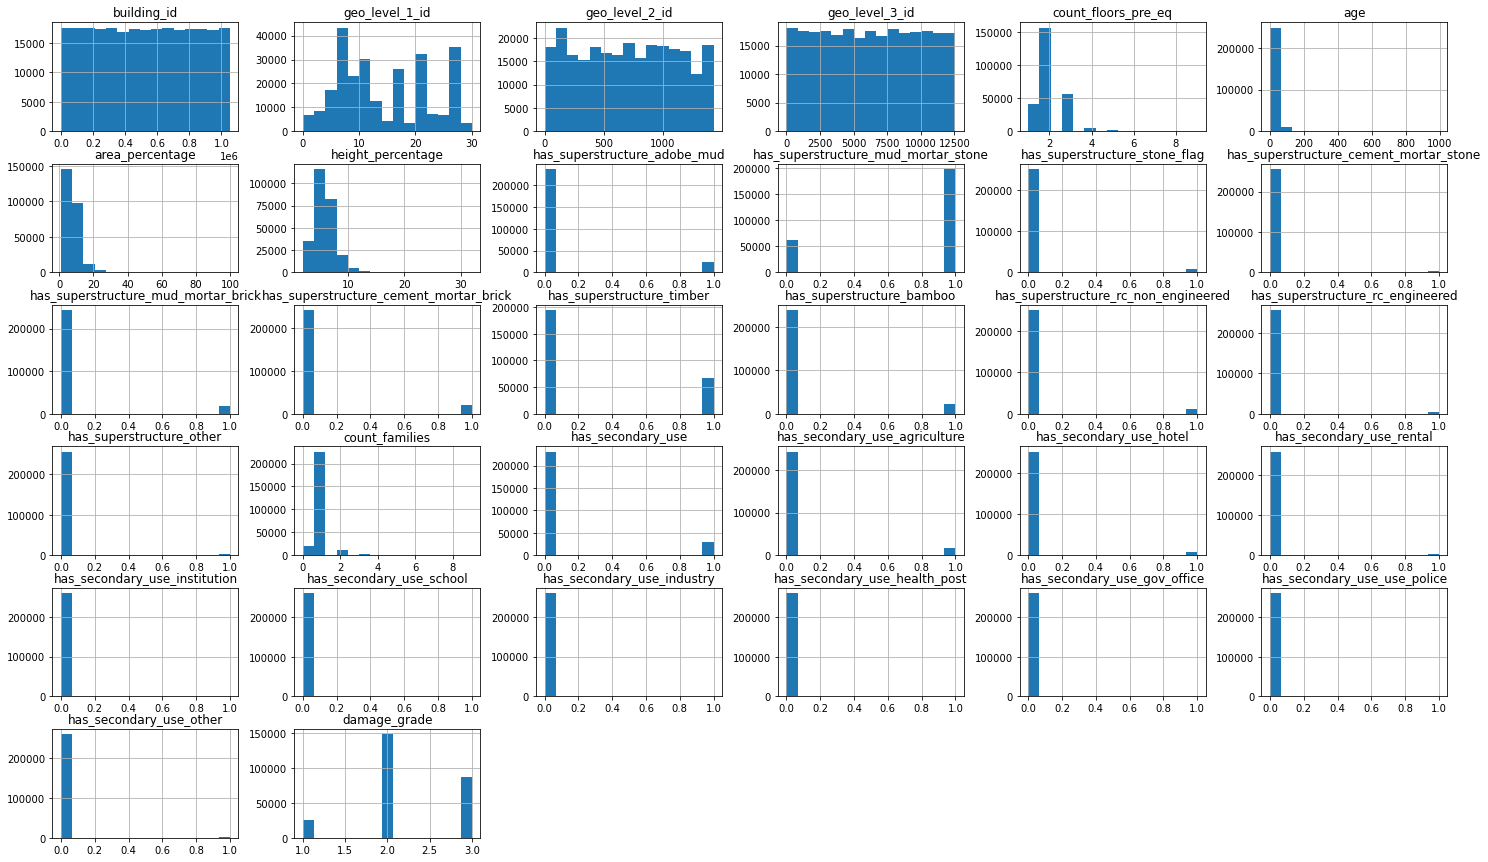

In [12]:
# Using pandas to make histograms
df.hist(figsize=(25,15), bins=15)
plt.show()

We also spotted the data set is imbalance distributed, we will need to deal with it in later step.

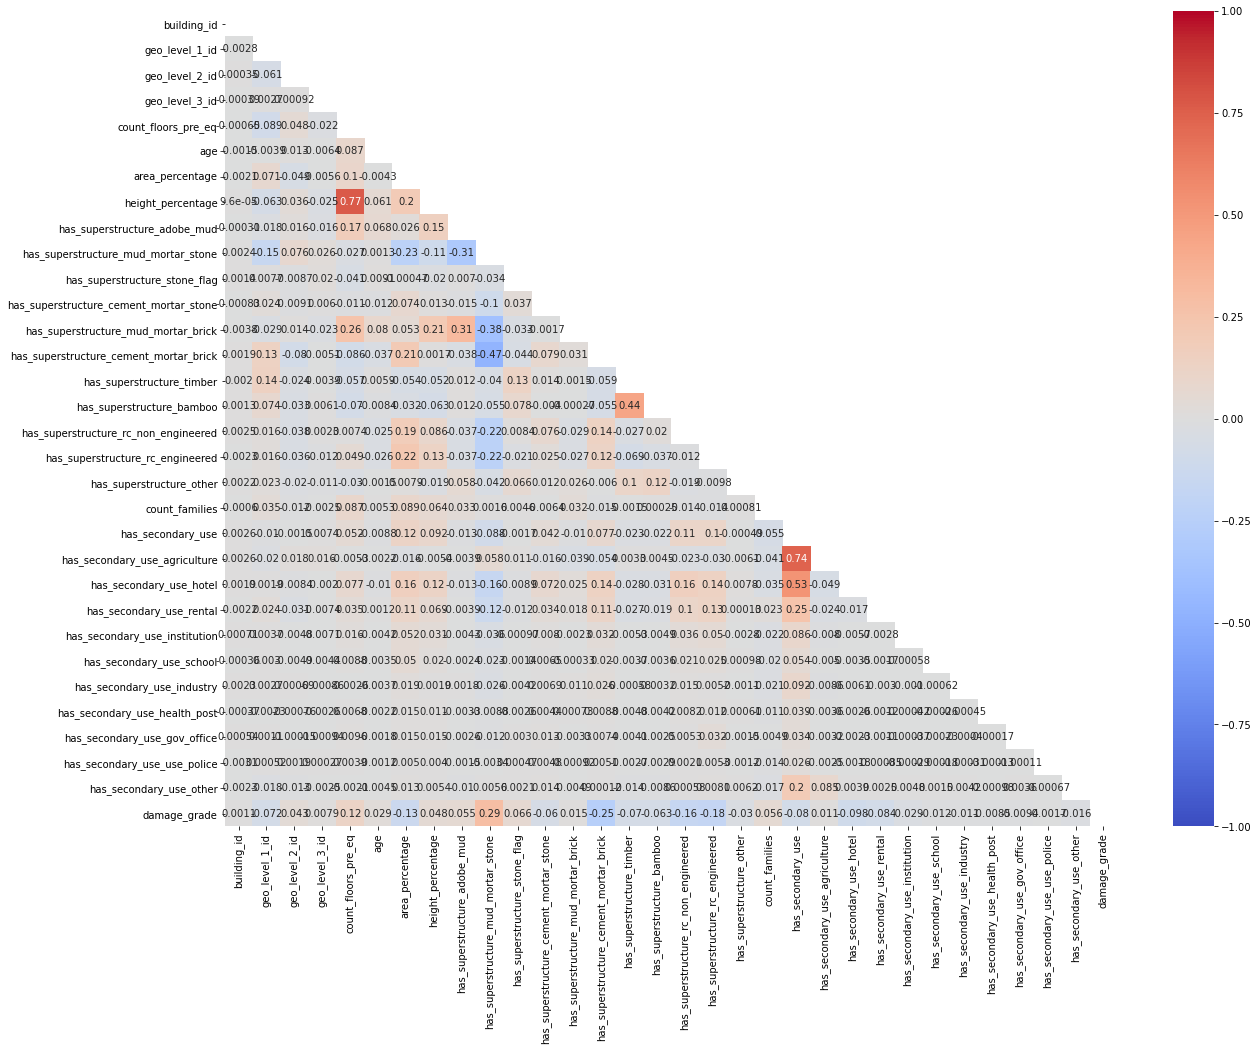

In [13]:
# Lets get the correlation matrix and save to variable 'corr_mat'
corr_mat = df.corr()
# Heatmap
plt.figure(figsize=(20,15))
matrix = np.triu(corr_mat)
sns.heatmap(corr_mat, cmap="coolwarm", vmin=-1, vmax=1, center=0, annot=True, mask=matrix)
plt.show()

### Data Cleaning

In [14]:
new_df = df.drop(['building_id'], axis = 1)

In [15]:
new_df['geo_level_1_id']= new_df['geo_level_1_id'].apply(str)
new_df['geo_level_2_id']= new_df['geo_level_2_id'].apply(str)
new_df['geo_level_3_id']= new_df['geo_level_3_id'].apply(str)

In [16]:
new_df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## 4. Modeling

In [17]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from category_encoders.wrapper import PolynomialWrapper

### Train test split

In [27]:
# Saving the features to 'X'
X = new_df.drop("damage_grade", axis=1)
# Saving target to 'y'
y = new_df["damage_grade"]

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Feature Engineering

In [39]:
obj_cols = list(new_df.select_dtypes(include=['object']))
obj_cols

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [28]:
te = ce.TargetEncoder(cols = obj_cols)
te.fit(X_rem, y_rem)    
X_rem_te = te.transform(X_rem)
X_test_te = te.transform(X_test)

## Cross Validation 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [29]:
LR_model = LogisticRegression()
DT_model = DecisionTreeClassifier()
RF_model = RandomForestClassifier()
LGBM_model = LGBMClassifier()

scores1 = cross_val_score(LR_model, X_rem_te, y_rem, cv=5, scoring = 'f1_micro')
scores2 = cross_val_score(DT_model, X_rem_te, y_rem, cv=5, scoring = 'f1_micro')
scores3 = cross_val_score(RF_model, X_rem_te, y_rem, cv=5, scoring = 'f1_micro')
scores4 = cross_val_score(LGBM_model, X_rem_te, y_rem, cv=5, scoring = 'f1_micro')

print("CV Scores:")
print(f"Logistic Regression score: {scores1.mean()}")
print(f"Decision Tree score: {scores2.mean()}")
print(f"Random Forest score: {scores3.mean()}")
print(f"LightGBM score: {scores4.mean()}")

CV Scores:
Logistic Regression score: 0.7215382085297666
Decision Tree score: 0.6688192084201294
Random Forest score: 0.7446113364762634
LightGBM score: 0.7554270365091547


LightGBM seems to perform the best in here, let's move forward with it.

## Hyperparameter Tuning

In [42]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
import catboost as cb

Since LightGBM offers good accuracy with integer-encoded categorical features, we can skip the step of target encoding. The algorithm only accept numeric input, we will first encode the categorical values into number using Ordinal Encoder.

In [43]:
oe = ce.OrdinalEncoder(cols = obj_cols)
oe.fit(X_rem, y_rem)
X_rem_oe = oe.transform(X_rem)
X_test_oe = oe.transform(X_test)

In [44]:
def objective(trial):
    
    param={
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 2000, step=20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 2000, step=100),
        "max_depth": trial.suggest_int("max_depth", 8, 12),
        'n_estimators': trial.suggest_int("n_estimators", 100, 200),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
        "random_state": 1,
    }

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'multi_logloss' )
    
    clf = LGBMClassifier(objective="softmax", num_class=3, n_jobs=8, is_unbalance=True, 
                         categorical_feature=[0,1,2,7,8,9,10,11,12,13,25], 
                         **param)
    
    clf.fit(X_rem_oe, y_rem, eval_set=[(X_test_oe, y_test)], verbose=0, early_stopping_rounds=100, callbacks=[pruning_callback])

    # Run CV to see how well these hyper_params do
    cv_scores = cross_val_score(clf, X_rem_oe, y_rem, cv=5, scoring="f1_macro")
    score = np.mean(cv_scores)
    
    return 1-score


if __name__ == "__main__":
    study = optuna.create_study(directions=["minimize"])
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-09-01 16:40:52,388] A new study created in memory with name: no-name-46a6474f-f5b9-4d65-810b-7bdc2dbb0225


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] min_gain_to_split is set=13.718977783215774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.718977783215774
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will b

[I 2022-09-01 16:41:05,613] Trial 0 finished with value: 0.3107987725792818 and parameters: {'learning_rate': 0.08320903789351866, 'num_leaves': 540, 'min_data_in_leaf': 120, 'max_depth': 9, 'n_estimators': 123, 'lambda_l1': 85, 'lambda_l2': 75, 'min_gain_to_split': 13.718977783215774, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.3107987725792818.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=1.026667933471714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026667933471714
[LightGBM] [Warning] min_data_in_leaf is set=1520, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1520
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will b

[I 2022-09-01 16:41:31,675] Trial 1 finished with value: 0.3150718577797601 and parameters: {'learning_rate': 0.044227090091535554, 'num_leaves': 380, 'min_data_in_leaf': 1520, 'max_depth': 12, 'n_estimators': 163, 'lambda_l1': 25, 'lambda_l2': 65, 'min_gain_to_split': 1.026667933471714, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.3107987725792818.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] min_gain_to_split is set=7.472355460961396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.472355460961396
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be 

[I 2022-09-01 16:41:40,875] Trial 2 finished with value: 0.3676270527692642 and parameters: {'learning_rate': 0.0909439617228356, 'num_leaves': 280, 'min_data_in_leaf': 720, 'max_depth': 11, 'n_estimators': 105, 'lambda_l1': 85, 'lambda_l2': 40, 'min_gain_to_split': 7.472355460961396, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.3107987725792818.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_gain_to_split is set=12.96650062088725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.96650062088725
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be 

[I 2022-09-01 16:41:57,205] Trial 3 finished with value: 0.3101065509853336 and parameters: {'learning_rate': 0.07964289430325518, 'num_leaves': 120, 'min_data_in_leaf': 720, 'max_depth': 8, 'n_estimators': 114, 'lambda_l1': 40, 'lambda_l2': 45, 'min_gain_to_split': 12.96650062088725, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 3 with value: 0.3101065509853336.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.2111441967560987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2111441967560987
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be i

[I 2022-09-01 16:42:20,302] Trial 4 finished with value: 0.29896474304516174 and parameters: {'learning_rate': 0.08533380240118416, 'num_leaves': 40, 'min_data_in_leaf': 120, 'max_depth': 12, 'n_estimators': 121, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 1.2111441967560987, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 4 with value: 0.29896474304516174.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] min_gain_to_split is set=7.194168704510565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.194168704510565
[LightGBM] [Warning] min_data_in_leaf is set=920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=920
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:42:21,013] Trial 5 pruned. Trial was pruned at iteration 5.
[I 2022-09-01 16:42:21,519] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:42:22,002] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:42:22,523] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:42:22,995] Trial 9 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=4.076449829920964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.076449829920964
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignor

[I 2022-09-01 16:42:55,672] Trial 10 finished with value: 0.2977557263787596 and parameters: {'learning_rate': 0.09936852043966912, 'num_leaves': 1880, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 199, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 4.076449829920964, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 10 with value: 0.2977557263787596.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.786249400715815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.786249400715815
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ign

[I 2022-09-01 16:43:27,493] Trial 11 finished with value: 0.2969052217105026 and parameters: {'learning_rate': 0.0999501203777669, 'num_leaves': 2000, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 196, 'lambda_l1': 0, 'lambda_l2': 100, 'min_gain_to_split': 3.786249400715815, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.2969052217105026.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=4.335409304714351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.335409304714351
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-09-01 16:43:28,021] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:43:28,566] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:43:32,735] Trial 14 pruned. Trial was pruned at iteration 114.
[I 2022-09-01 16:43:33,272] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:43:37,303] Trial 16 pruned. Trial was pruned at iteration 114.
[I 2022-09-01 16:43:37,862] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:43:38,460] Trial 18 pruned. Trial was pruned at iteration 1.
[I 2022-09-01 16:43:38,970] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:43:39,476] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:43:44,252] Trial 21 pruned. Trial was pruned at iteration 123.
[I 2022-09-01 16:43:49,952] Trial 22 pruned. Trial was pruned at iteration 114.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=0.3088727974516159, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3088727974516159
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will

[I 2022-09-01 16:44:11,221] Trial 23 finished with value: 0.29890819266506874 and parameters: {'learning_rate': 0.09156958332506426, 'num_leaves': 1820, 'min_data_in_leaf': 220, 'max_depth': 11, 'n_estimators': 100, 'lambda_l1': 10, 'lambda_l2': 100, 'min_gain_to_split': 0.3088727974516159, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.2969052217105026.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_gain_to_split is set=0.25054471503926745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25054471503926745
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 wi

[I 2022-09-01 16:44:33,457] Trial 24 finished with value: 0.2982748621821478 and parameters: {'learning_rate': 0.09415321173406462, 'num_leaves': 1840, 'min_data_in_leaf': 320, 'max_depth': 11, 'n_estimators': 105, 'lambda_l1': 20, 'lambda_l2': 100, 'min_gain_to_split': 0.25054471503926745, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.2969052217105026.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_gain_to_split is set=10.865993300370835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.865993300370835
[LightGBM] [Warning] min_data_in_leaf is set=920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=920
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-09-01 16:44:34,036] Trial 25 pruned. Trial was pruned at iteration 2.
[I 2022-09-01 16:44:36,520] Trial 26 pruned. Trial was pruned at iteration 60.
[I 2022-09-01 16:44:37,128] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:44:37,661] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:44:38,186] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:44:38,902] Trial 30 pruned. Trial was pruned at iteration 4.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=0.07024376434114776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07024376434114776
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will 

[I 2022-09-01 16:44:59,994] Trial 31 finished with value: 0.29828463322167953 and parameters: {'learning_rate': 0.0935045132826222, 'num_leaves': 1820, 'min_data_in_leaf': 220, 'max_depth': 10, 'n_estimators': 105, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 0.07024376434114776, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.2969052217105026.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=0.26667684474214004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26667684474214004
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-09-01 16:45:03,047] Trial 32 pruned. Trial was pruned at iteration 64.
[I 2022-09-01 16:45:03,650] Trial 33 pruned. Trial was pruned at iteration 1.
[I 2022-09-01 16:45:04,177] Trial 34 pruned. Trial was pruned at iteration 1.
[I 2022-09-01 16:45:04,822] Trial 35 pruned. Trial was pruned at iteration 2.
[I 2022-09-01 16:45:05,480] Trial 36 pruned. Trial was pruned at iteration 1.
[I 2022-09-01 16:45:06,142] Trial 37 pruned. Trial was pruned at iteration 1.
[I 2022-09-01 16:45:06,676] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:45:07,268] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:45:11,214] Trial 40 pruned. Trial was pruned at iteration 87.
[I 2022-09-01 16:45:12,001] Trial 41 pruned. Trial was pruned at iteration 2.
[I 2022-09-01 16:45:12,679] Trial 42 pruned. Trial was pruned at iteration 4.
[I 2022-09-01 16:45:13,382] Trial 43 pruned. Trial was pruned at iteration 2.
[I 2022-09-01 16:45:14,083] Trial 44 pruned. Trial was pruned 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.2222331363585148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2222331363585148
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be

[I 2022-09-01 16:45:44,663] Trial 51 finished with value: 0.2982956552480991 and parameters: {'learning_rate': 0.09999106057346709, 'num_leaves': 80, 'min_data_in_leaf': 120, 'max_depth': 12, 'n_estimators': 107, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 1.2222331363585148, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.2969052217105026.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=1.0496559243455115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0496559243455115
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-09-01 16:45:48,177] Trial 52 pruned. Trial was pruned at iteration 79.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.4732304356439696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4732304356439696
[LightGBM] [Warning] min_data_in_leaf is set=420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=420
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be i

[I 2022-09-01 16:46:14,702] Trial 53 finished with value: 0.2975110207927263 and parameters: {'learning_rate': 0.09978519827645699, 'num_leaves': 560, 'min_data_in_leaf': 420, 'max_depth': 12, 'n_estimators': 110, 'lambda_l1': 5, 'lambda_l2': 95, 'min_gain_to_split': 1.4732304356439696, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.2969052217105026.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=1.56829055323536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.56829055323536
[LightGBM] [Warning] min_data_in_leaf is set=420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=420
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001


[I 2022-09-01 16:46:17,170] Trial 54 pruned. Trial was pruned at iteration 47.
[I 2022-09-01 16:46:20,612] Trial 55 pruned. Trial was pruned at iteration 69.
[I 2022-09-01 16:46:21,284] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:46:21,917] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:46:22,598] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:46:23,346] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:46:24,164] Trial 60 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:46:25,347] Trial 61 pruned. Trial was pruned at iteration 7.
[I 2022-09-01 16:46:26,355] Trial 62 pruned. Trial was pruned at iteration 7.
[I 2022-09-01 16:46:33,558] Trial 63 pruned. Trial was pruned at iteration 73.
[I 2022-09-01 16:46:34,353] Trial 64 pruned. Trial was pruned at iteration 2.
[I 2022-09-01 16:46:35,022] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:46:35,905] Trial 66 pruned. Trial was pruned

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=0.04890132865955302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04890132865955302
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be i

[I 2022-09-01 16:47:11,575] Trial 67 finished with value: 0.2949108386340553 and parameters: {'learning_rate': 0.09635715903083934, 'num_leaves': 1340, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 115, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 0.04890132865955302, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=2.4031748570098674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4031748570098674
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ign

[I 2022-09-01 16:47:37,278] Trial 68 finished with value: 0.2960691270703205 and parameters: {'learning_rate': 0.09696013051912465, 'num_leaves': 1120, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 114, 'lambda_l1': 5, 'lambda_l2': 80, 'min_gain_to_split': 2.4031748570098674, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=2.395718496814032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.395718496814032
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignor

[I 2022-09-01 16:48:04,066] Trial 69 finished with value: 0.29582600324943187 and parameters: {'learning_rate': 0.0960256263280268, 'num_leaves': 1080, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 122, 'lambda_l1': 0, 'lambda_l2': 80, 'min_gain_to_split': 2.395718496814032, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.597829037369165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.597829037369165
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignor

[I 2022-09-01 16:48:32,611] Trial 70 finished with value: 0.29573812638077424 and parameters: {'learning_rate': 0.09617513808913626, 'num_leaves': 1120, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 123, 'lambda_l1': 0, 'lambda_l2': 80, 'min_gain_to_split': 3.597829037369165, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=5.19863712951889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.19863712951889
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:48:36,443] Trial 71 pruned. Trial was pruned at iteration 77.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=2.3426948610957767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3426948610957767
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ign

[I 2022-09-01 16:49:02,538] Trial 72 finished with value: 0.295532977351025 and parameters: {'learning_rate': 0.08943591918182042, 'num_leaves': 960, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 125, 'lambda_l1': 0, 'lambda_l2': 60, 'min_gain_to_split': 2.3426948610957767, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=3.4989674670425717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4989674670425717
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:49:03,557] Trial 73 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_gain_to_split is set=2.561949940833916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.561949940833916
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignor

[I 2022-09-01 16:49:29,320] Trial 74 finished with value: 0.295548360292071 and parameters: {'learning_rate': 0.09633764923511987, 'num_leaves': 1320, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 130, 'lambda_l1': 0, 'lambda_l2': 75, 'min_gain_to_split': 2.561949940833916, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=2.406580240710908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.406580240710908
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:49:29,885] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:49:34,650] Trial 76 pruned. Trial was pruned at iteration 99.
[I 2022-09-01 16:49:35,250] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:49:35,825] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:49:36,376] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:49:37,001] Trial 80 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_gain_to_split is set=4.177611472091344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.177611472091344
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignor

[I 2022-09-01 16:50:00,926] Trial 81 finished with value: 0.2959350860774975 and parameters: {'learning_rate': 0.09776157105748952, 'num_leaves': 860, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 137, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 4.177611472091344, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=4.1429827396042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.1429827396042
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignore

[I 2022-09-01 16:50:24,234] Trial 82 finished with value: 0.2959247545885908 and parameters: {'learning_rate': 0.09743644193817555, 'num_leaves': 840, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 138, 'lambda_l1': 10, 'lambda_l2': 75, 'min_gain_to_split': 4.1429827396042, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=4.471682435532539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.471682435532539
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:50:25,658] Trial 83 pruned. Trial was pruned at iteration 25.
[I 2022-09-01 16:50:29,442] Trial 84 pruned. Trial was pruned at iteration 92.
[I 2022-09-01 16:50:29,991] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:50:30,512] Trial 86 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_gain_to_split is set=3.6455864845234225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6455864845234225
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be 

[I 2022-09-01 16:50:53,448] Trial 87 finished with value: 0.29586240443117995 and parameters: {'learning_rate': 0.0977024353968129, 'num_leaves': 740, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 130, 'lambda_l1': 10, 'lambda_l2': 75, 'min_gain_to_split': 3.6455864845234225, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_gain_to_split is set=2.547254204885756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.547254204885756
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:50:53,997] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:50:54,523] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:50:55,056] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:50:55,955] Trial 91 pruned. Trial was pruned at iteration 10.
[I 2022-09-01 16:50:59,144] Trial 92 pruned. Trial was pruned at iteration 71.
[I 2022-09-01 16:50:59,892] Trial 93 pruned. Trial was pruned at iteration 4.
[I 2022-09-01 16:51:00,416] Trial 94 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=3.479110046504176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.479110046504176
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ig

[I 2022-09-01 16:51:24,297] Trial 95 finished with value: 0.2964097193063746 and parameters: {'learning_rate': 0.09763050449739374, 'num_leaves': 1300, 'min_data_in_leaf': 20, 'max_depth': 12, 'n_estimators': 136, 'lambda_l1': 15, 'lambda_l2': 70, 'min_gain_to_split': 3.479110046504176, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 67 with value: 0.2949108386340553.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=3.532452837563807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.532452837563807
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-09-01 16:51:24,916] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:51:25,510] Trial 97 pruned. Trial was pruned at iteration 1.
[I 2022-09-01 16:51:26,037] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2022-09-01 16:51:26,934] Trial 99 pruned. Trial was pruned at iteration 9.


Number of finished trials: 100
Best trial:
  Value: 0.2949108386340553
  Params: 
    learning_rate: 0.09635715903083934
    num_leaves: 1340
    min_data_in_leaf: 20
    max_depth: 12
    n_estimators: 115
    lambda_l1: 5
    lambda_l2: 90
    min_gain_to_split: 0.04890132865955302
    bagging_fraction: 0.9
    bagging_freq: 1
    feature_fraction: 0.9


## 5. Evaluation

Let's also test the model with test set

In [48]:
cv_LGBM = LGBMClassifier(
    objective='softmax', num_class=3, n_jobs=8, is_unbalance=True, n_estimators=115, 
    learning_rate=0.09635715903083934, num_leaves=1340, min_data_in_leaf=20, max_depth=12,
    lambda_l1=5, lambda_l2=90, min_gain_to_split=0.04890132865955302, bagging_fraction=0.9, bagging_freq=1,
    feature_fraction=0.9, categorical_feature=[0,1,2,7,8,9,10,11,12,13,25]
).fit(X_rem_oe, y_rem)
# Print the accuracies
print(f'Accuracy on remainder set: {cv_LGBM.score(X_rem_oe, y_rem)}')
print(f'Accuracy on test set: {cv_LGBM.score(X_test_oe, y_test)}')

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.04890132865955302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04890132865955302
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Accuracy on remainder set: 0.7902313342835215
Accuracy on test set: 0.7455264066716977


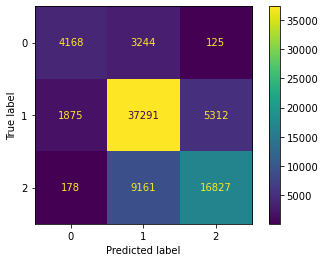

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = cv_LGBM.predict(X_test_oe)
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
# Plot
ConfusionMatrixDisplay(cf_matrix).plot()

In [51]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           1       0.67      0.55      0.61      7537
           2       0.75      0.84      0.79     44478
           3       0.76      0.64      0.69     26166

    accuracy                           0.75     78181
   macro avg       0.73      0.68      0.70     78181
weighted avg       0.74      0.75      0.74     78181



The model performed the best on predicting class 2. Consider the fact that the data set was imbalance, the model performed not bad overall.

<AxesSubplot:>

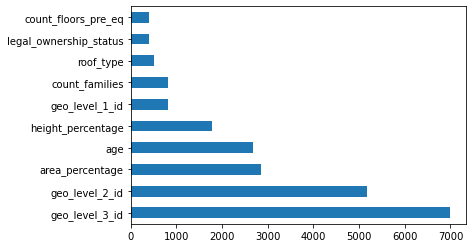

In [92]:
feat_importances = pd.Series(cv_LGBM.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

## 6. Build a Pipeline

Build a pipeline and fit the final model with all available data.

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id',
                        'land_surface_condition','foundation_type','roof_type',
                        'ground_floor_type','other_floor_type','position','plan_configuration',
                        'legal_ownership_status']
drop_features = ['building_id']

clf = LGBMClassifier(
    objective='softmax', num_class=3, n_jobs=8, is_unbalance=True, n_estimators=115, 
    learning_rate=0.09635715903083934, num_leaves=1340, min_data_in_leaf=20, max_depth=12,
    lambda_l1=5, lambda_l2=90, min_gain_to_split=0.04890132865955302, bagging_fraction=0.9, bagging_freq=1,
    feature_fraction=0.9, categorical_feature=[0,1,2,7,8,9,10,11,12,13,25]
)

categorical_transformer = Pipeline(steps=[
      ('encoder', ce.OrdinalEncoder()),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('drop', 'drop', drop_features)],
            remainder = 'passthrough', 
            sparse_threshold=0)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('clf', clf)])

In [71]:
pipe.fit(df_x, df_y['damage_grade'])

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.04890132865955302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04890132865955302
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['geo_level_1_id',
                                                                    'geo_level_2_id',
                                                                    'geo_level_3_id',
                                                                    'land_surface_condition',
                                                                    'foundation_type',
                                                                    'roof_type',
                                                                    'ground_floor_type',
                                                                    'other_floor_type',
                                                                    'position',
                                                                    'plan_conf...
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9, bagging_freq=1,
                                categorical_feature=[0, 1, 2, 7, 8, 9, 10, 11,
                                                     12, 13, 25],
                                feature_fraction=0.9, is_unbalance=True,
                                lambda_l1=5, lambda_l2=90,
                                learning_rate=0.09635715903083934, max_depth=12,
                                min_data_in_leaf=20,
                                min_gain_to_split=0.04890132865955302,
                                n_estimators=115, n_jobs=8, num_class=3,
                                num_leaves=1340, objective='softmax'))])

In [74]:
import joblib

In [75]:
# save the final model
joblib.dump(clf, 'my_LGBM.pkl') 

['my_LGBM.pkl']

## 7. Make Prediction

Make prediction on the test set with the final model.

In [76]:
df2 = pd.read_csv('test_values.csv')

In [78]:
prediction = pipe.predict(df2)

In [79]:
df_pred = pd.DataFrame(prediction, index = df2['building_id'], columns = ['damage_grade'])
df_pred = df_pred.reset_index(level=0)

In [80]:
df_pred

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [81]:
df_pred.to_csv('result0901.csv', index = False)